In [1]:
import ROOT
import root_numpy as rnpy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pickle

Welcome to ROOTaaS 6.06/08


In [102]:
batch_size_jets = 25
batch_size_tracks = 25
read_pos_jets = 0
read_pos_tracks = 0

In [103]:
d1 = pd.DataFrame(rnpy.root2array("/mnt/t3nfs01/data01/shome/jpata/btv/gc/TagVarExtractor/GCa08e5e237323/TT_TuneCUETP8M1_13TeV-powheg-pythia8/job_0_out.root",
                                 treename = "tagVars/ttree", start = read_pos_jets, stop = read_pos_jets + batch_size_jets))

In [104]:
d2 = pd.DataFrame(rnpy.root2array("/mnt/t3nfs01/data01/shome/jpata/btv/gc/TagVarExtractor/GCa08e5e237323/TT_TuneCUETP8M1_13TeV-powheg-pythia8/job_0_out.root",
                                 treename = "tagVars/ttree_track", start = read_pos_tracks, stop = read_pos_tracks + batch_size_tracks))

/swshare/anaconda/lib/python2.7/site-packages/root_numpy/_tree.py:209: RuntimeWarning: ignoring duplicate branch named 'Track_nHitPixel'
  warn_missing_tree)


In [105]:
last_tracks = (int)(d2.tail(1)['Track_jetIndex'].iloc[0]-1)

In [106]:
last_jet = (int)(d1.tail(1)['Jet_jetIndex'].iloc[0]-1)

In [107]:
read_pos_jets += (d1.loc[d1['Jet_jetIndex'] == last_tracks].index[-1] + 1)
read_pos_tracks += (d2.loc[d2['Track_jetIndex'] == last_tracks].index[-1] + 1)

In [108]:
d1['track_data'] = pd.np.empty((len(d1.index), 0)).tolist()

In [109]:
# iterate over the track list to join jets with the tracks belonging to them
for irow, row in d2.iterrows():
    # these are the track data of the current track:
    tracks = row[["Track_pt", "Track_eta", "Track_phi", "Track_dxy", "Track_dz", "Track_IP", "Track_IP2D", "Track_length"]].as_matrix()
    jet_index = int(row["Track_jetIndex"])
    if jet_index > last_tracks:
        break
    table_index = d1.loc[d1['Jet_jetIndex'] == jet_index].index[0]
    
    # append the tracks data to the matching jet in the main table
    d1['track_data'][table_index].append(tracks)

In [4]:
def get_max_tracks(data):
    retval = 0
    for cur in data['track_data']:
        if len(cur) > retval:
            retval = len(cur)
    return retval

In [5]:
def equalize_tracks(data, set_tracks):
    empty = np.full(8, 0, float)
    for idx, cur in enumerate(data['track_data']):
        # take only these that are non-empty track lists
        if(len(cur) > 0):
            for i in range(set_tracks - len(cur)):
                data['track_data'][idx].append(empty)

In [6]:
def create_track_columns(set_tracks, number_parameters):
    colnames = []
    for i in range(set_tracks * number_parameters):
        colnames.append('T' + str(i))
    return colnames

In [7]:
def create_track_table(data):
    set_tracks = len(data['track_data'][0])
    number_parameters = len(data['track_data'][0][0])
    
    tracks = []
    colnames = create_track_columns(set_tracks, number_parameters)
    
    for cur in data['track_data']:
        arr = np.array(cur)
        tracks.append(arr.flatten())
        
    return pd.DataFrame(tracks, columns=colnames)

In [8]:
def create_track_list(table, set_tracks, number_parameters):
    number_jets = len(table)
    cols = create_track_columns(set_tracks, number_parameters)

    # extract raw matrix
    tracks = table.ix[:,cols].as_matrix()
    return tracks.reshape(number_jets, -1, number_parameters)

In [10]:
set_tracks = 10
number_parameters = 8

In [153]:
equalize_tracks(matched, set_tracks)

In [23]:
track_table = create_track_table(d1)

In [24]:
joined = pd.concat([d1.ix[:,0:-1], track_table], axis = 1)

In [25]:
tracks_reconstructed = create_track_list(joined, set_tracks, number_parameters)

In [146]:
matched = d1.loc[d1['Jet_jetIndex'] < 30]

In [150]:
matched = matched.loc[lengths > 0]

In [152]:
matched

,Jet_jetIndex,Jet_pt,Jet_genpt,Jet_eta,Jet_phi,Jet_mass,Jet_flavour,Jet_nbHadrons,Jet_JP,Jet_JBP,...,TagVarCSV_trackJetDist_3,TagVarCSV_trackDecayLenVal_0,TagVarCSV_trackDecayLenVal_1,TagVarCSV_trackDecayLenVal_2,TagVarCSV_trackDecayLenVal_3,TagVarCSV_trackEtaRel_0,TagVarCSV_trackEtaRel_1,TagVarCSV_trackEtaRel_2,TagVarCSV_trackEtaRel_3,track_data
0,0,182.438431,163.630890,-0.237132,-2.236427,16.854450,-4.0,0.0,0.880459,3.552757,...,-99.000000,1.934348,0.011753,0.026479,-99.000000,4.764413,3.611055,3.247250,-99.000000,"[[17.8906, -0.222114, -2.24089, 0.02125, -0.02..."
1,1,67.666817,48.347958,1.526484,1.863574,11.641233,2.0,0.0,0.504102,2.620981,...,-0.002323,0.020211,0.819694,0.020396,2.094727,3.716417,4.664929,-99.000000,-99.000000,"[[2.16211, 1.84118, 1.70083, 0.0012561, -0.052..."
2,2,67.311432,75.550545,1.085625,-0.154507,11.436769,5.0,1.0,1.383020,6.356793,...,-99.000000,1.709969,3.066908,0.376480,-99.000000,4.372991,5.275004,3.397882,3.878511,"[[2.53906, 1.15928, -0.062994, -0.015498, -0.0..."


In [143]:
d1['Jet_jetIndex'] < 30 and lengths < 4

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [148]:
lengths = np.array(map(len, matched['track_data']))

In [149]:
lengths < 4

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [131]:
def save_dataset(file, data):
    store = pd.HDFStore(file)
    store.put('data', data, format = 'table')
    store.close()

In [517]:
save_dataset('./padded_test.h5', joined)

In [38]:
# now divide the jets and put them in separate lists, according to their flavour
jets_b = []
jets_l = []
jets_c = []

# iterate over the jet list, with already matched tracks
for irow, row in d1.iterrows():
    jet_index = int(row["Jet_jetIndex"])
    if jet_index > last_tracks:
        break
    
    flavour = int(row["Jet_flavour"])
    
    # select the right list this jet belongs to
    if abs(flavour) == 5:
        jets = jets_b
    elif abs(flavour) == 4:
        jets = jets_c
    else:
        jets = jets_l
        
    # add the new jet to the list
    jets += [(row["Jet_pt"], row["Jet_eta"], row["Jet_phi"], row["Jet_mass"], flavour, row["track_data"])]

In [12]:
def read_metadata(store):
    return store.get_storer('data').attrs.metadata

In [13]:
with pd.HDFStore('/shome/phwindis/data/matched/1.h5') as store:
    metadata = read_metadata(store)
number_tracks = metadata['number_tracks']

In [10]:
metadata

{'number_jets': 218280, 'number_tracks': 33}

In [3]:
readin = pd.read_hdf('/shome/phwindis/data/matched/1.h5', start = 0, stop = 100)

In [14]:
tracks_reconstructed = create_track_list(readin, 10, number_parameters)

In [100]:
ind = range(0,3)
ind

[0, 1, 2]

In [130]:
tracks_reconstructed[2,:,:]

array([[  2.34218750e+01,  -9.15555298e-01,  -2.86981368e+00,
          1.05224608e-03,  -6.43920910e-04,   1.14220753e-03,
          1.05224538e-03,   4.23577148e-03],
       [  6.16796875e+00,  -9.75249469e-01,  -2.96161556e+00,
         -2.20825220e-03,  -7.34252913e-04,  -2.26085447e-03,
         -2.20825709e-03,   8.52708798e-03],
       [  3.14687500e+01,  -1.29825735e+00,  -2.78221345e+00,
          1.44921876e-02,  -1.52221625e-03,  -1.45128192e-02,
         -1.44921876e-02,   5.95761873e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

In [141]:
tracks_reconstructed[2,:,0:2]

array([[ 23.421875  ,  -0.9155553 ],
       [  6.16796875,  -0.97524947],
       [ 31.46875   ,  -1.29825735],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [144]:
tracks_reconstructed[2,:,[0,1]]

array([[ 23.421875  ,   6.16796875,  31.46875   ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -0.9155553 ,  -0.97524947,  -1.29825735,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]])

In [26]:
tracks_sorted = np.array([sorted(cur, key = lambda tracks: tracks[0], reverse = True) for cur in tracks_reconstructed])

In [151]:
test = np.random.rand(3)
test

array([ 0.88478134,  0.61414504,  0.08700125])

In [154]:
ind = np.array([1,0,1])

In [157]:
test[ind == 0]

array([ 0.61414504])

In [88]:
flavours = np.array(abs(readin['Jet_flavour']) == 5)

In [89]:
np.array(flavours) * 1

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0])

In [90]:
flavours = flavours * 1

In [91]:
flavours.reshape((len(flavours),1))

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [98]:
readin.loc[14]

Jet_jetIndex                         14.000000
Jet_pt                               84.502274
Jet_genpt                            87.487740
Jet_eta                              -2.325445
Jet_phi                               1.617444
Jet_mass                              8.225379
Jet_flavour                          -2.000000
Jet_nbHadrons                         0.000000
Jet_JP                               -0.000000
Jet_JBP                              -0.000000
Jet_CSV                             -10.000000
Jet_CSVIVF                          -10.000000
Jet_cMVA                             -0.853212
Jet_SoftMu                                -inf
Jet_SoftEl                                -inf
Jet_CTag_CvsL                         0.298788
Jet_CTag_CvsB                        -0.288275
Jet_nTracks                           0.000000
TagVarCSV_jetNTracks                  0.000000
TagVarCSV_jetNTracksEtaRel            0.000000
TagVarCSV_trackSumJetEtRatio        -99.000000
TagVarCSV_tra

In [99]:
tracks_reconstructed[13]

array([[  2.52343750e+00,   1.57255781e+00,  -2.06553146e-01,
         -3.70117184e-03,  -1.37695316e-02,   6.61189901e-03,
          3.70117556e-03,   7.70495534e-02],
       [  2.40039062e+00,   1.49821472e+00,  -2.27737248e-01,
         -1.24084472e-03,   2.46093748e-03,  -1.62413588e-03,
          1.24085054e-03,   2.07710937e-02],
       [  2.59960938e+00,   1.22135079e+00,  -4.21110362e-01,
          1.97998038e-03,   1.19238282e-02,   6.76507596e-03,
          1.97998341e-03,   4.77084294e-02],
       [  1.73339844e+00,   1.11038542e+00,  -4.61543173e-01,
          4.85839881e-03,   6.30371086e-03,   6.13528350e-03,
          4.85840114e-03,   3.04672290e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

In [73]:
tracks_reconstructed[5]

array([[  1.07324219e+00,   1.36088133e+00,   7.34601855e-01,
          6.87988289e-03,   2.25781258e-02,  -1.28598604e-02,
         -6.87987963e-03,   5.45373261e-02],
       [  1.01171875e+00,   1.23838007e+00,   4.66332495e-01,
          3.17871105e-03,  -1.04882810e-02,   6.44701766e-03,
         -3.17871035e-03,   5.27326800e-02],
       [  7.33203125e+00,   1.14755702e+00,   4.35461164e-01,
         -4.87365760e-04,  -7.88085908e-03,  -4.57146252e-03,
          4.87362093e-04,   4.47173491e-02],
       [  3.57187500e+01,   1.14554274e+00,   3.97668123e-01,
         -5.34362800e-04,   5.91308577e-03,   3.45720048e-03,
         -5.34359540e-04,   1.08034730e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

In [165]:
x = np.random.rand(10)

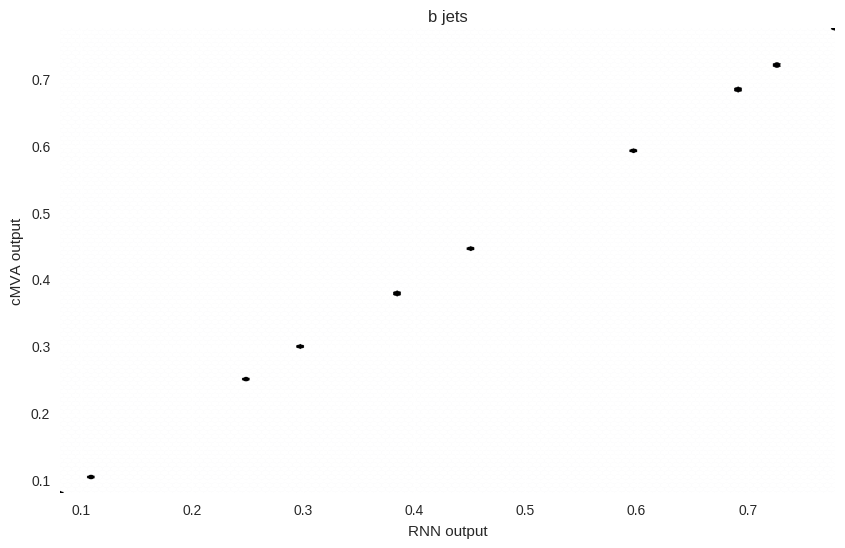

In [166]:
fig = plt.figure(figsize=(10,6))
plt.hexbin(x, x, gridsize = 100)
plt.title('b jets')
plt.xlabel('RNN output')
plt.ylabel('cMVA output')
plt.show()
